# Data Import


In [2]:
import pandas as pd 
import numpy as np
from pathlib import Path 
from src import params
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt 

In [6]:
dataset='SHARE'


df = params.data_reader(source='us',dataset=dataset,bio=False,platform='jupyter')
model_params=params.model_params



In [7]:
# generating death age
df['death_age']= [age if death==1 else None for age,death in zip(df['age'],df['death'])]
df['death_age'].describe()

# select only rows with death_age != None 
model_params['y_colname']='death_age'
df=df.loc[df['death_age'].notna(),]
df.shape

(4327, 36)

In [5]:
df_HRS=df.copy()
df_HRS['dataset']=0

In [8]:
df_SHARE=df.copy()
col='ZwealthT'
df_SHARE[col]=df_SHARE[col]-np.mean(df_SHARE[col])
df_SHARE[col]=df_SHARE[col]/np.std(df_SHARE[col])
df_SHARE['dataset']=1

In [17]:
df=pd.merge(left=df_SHARE,right=df_HRS,how='outer')

In [18]:
# remove age from the prediction
df.drop(['age'],inplace=True,axis=1)
model_params['domain_dict']['all'].remove('age')

In [22]:
from sklearn.model_selection import train_test_split 
domain_vars = list(set(model_params['domain_dict']['all']).intersection(set(df.columns)) )
df=df[domain_vars+['death_age']]
df.dropna(axis=1,inplace=True)

X,X_test,y,y_test = train_test_split(df.drop(['death_age'],axis=1),df['death_age'],
                                     test_size = model_params['test_size'],
                                    random_state=model_params['random_state'])

In [23]:
df.shape

(8401, 24)

In [28]:
# model = xgb.XGBRegressor()
model = lgb.LGBMRegressor()
model.fit(X,y)
y_test_pred=model.predict(X_test)
# store result
df_res = pd.DataFrame(columns = ['true_age','xgb_predict'])
df_res['true_age']=y_test
df_res['xgb_predict']=y_test_pred
#df_res['xgb_predict']=df_res['xgb_predict'].round(1)

In [25]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

def regression_evaluation(true,pred):
    mse = mean_squared_error(true, pred, squared=True)
    rmse = mean_squared_error(true, pred, squared=False)
    mae = mean_absolute_error(true, pred)

    print(f'MSE={mse}\nRMSE={rmse}\nMAE={mae}')


In [26]:
regression_evaluation(df_res['true_age'],df_res['xgb_predict'])

MSE=63.30295338449155
RMSE=7.956315314546775
MAE=6.191015858633184


In [29]:
regression_evaluation(df_res['true_age'],df_res['xgb_predict'])

MSE=58.256278043487946
RMSE=7.632580038459338
MAE=5.959346956632413


(46.0, 102.0)

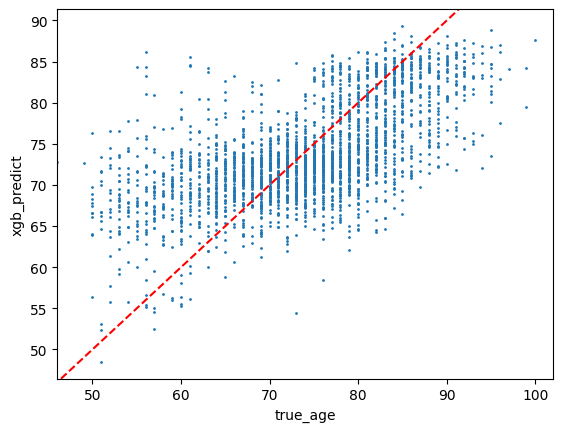

In [30]:
fig,ax = plt.subplots(1,1)

df_res.plot.scatter(x='true_age',y='xgb_predict',ax=ax,s=1)
ax.axline((55,55),slope=1,color='red',linestyle='--')
ax.set_xlim(46,102)